# Import libraries

In [35]:
import os
from re import search
from dfply import *
import igraph
import fa2

# Load settings

In [36]:
if search("ricard", os.uname()[1]):
    exec(open('/Users/argelagr/gastrulation10x/settings.py').read())
    exec(open('/Users/ricard/gastrulation10x/utils.py').read())
elif search("BI2404M", os.uname()[1]):
    exec(open('/Users/argelagr/gastrulation10x/settings.py').read())
    exec(open('/Users/argelagr/gastrulation10x/utils.py').read())
else:
    exit("Computer not recognised")

## Define I/O

In [37]:
io["outdir"] = io["basedir"] + "/results/trajectories/nmp_scanpy"

## Define options 

scanpy options

In [38]:
# %%capture
# sc.settings.verbosity = 3
# sc.logging.print_versions()
sc.settings.figdir = io["outdir"]
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(8, 7), facecolor='white')

In [39]:
opts["stages"] = [
	"E6.5",
	"E6.75",
	"E7.0",
	"E7.25",
	"E7.5",
	"E7.75",
	"E8.0",
	"E8.25",
	"E8.5",
	"mixed_gastrulation"
]

opts["celltypes"] = [
   "Rostral_neurectoderm",
   "Forebrain_Midbrain_Hindbrain",
   "Neural_crest"
]

## Load cell metadata

In [40]:
metadata = (pd.read_table(io["metadata"]) >>
    mask(X["stripped"]==False, X["doublet"]==False) >>
    mask(X["stage"].isin(opts["stages"]), X["celltype"].isin(opts["celltypes"]))
)
metadata.shape

(10868, 12)

In [41]:
metadata.head()

,cell,barcode,sample,stage,sequencing.batch,doublet,stripped,celltype,umapX,umapY,nFeature_RNA,nCount_RNA
4,cell_10000,GTAGGTACGTGTTG,8,E7.75,1,False,False,Rostral_neurectoderm,-7.366817,-2.281955,4492,24351
5,cell_100000,GACTGATGACACAC,29,E8.5,3,False,False,Forebrain_Midbrain_Hindbrain,-0.918522,-5.517593,3217,14074
6,cell_100001,GACTGATGACGTTG,29,E8.5,3,False,False,Forebrain_Midbrain_Hindbrain,0.560868,-7.265336,3751,19012
10,cell_100005,GACTGTGAGCTGAT,29,E8.5,3,False,False,Forebrain_Midbrain_Hindbrain,0.867244,-5.229906,3985,21722
14,cell_100009,GACTGTGATGAACC,29,E8.5,3,False,False,Forebrain_Midbrain_Hindbrain,0.578565,-5.938985,3658,19062


# Load anndata object

In [42]:
adata = load_adata(
    adata_file = io["anndata"], 
    metadata_file = io["metadata"],
    cells = metadata.cell.values, 
    normalise = True, 
    filter_lowly_expressed_genes = True
)
adata

/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 10868 × 15979
    obs: 'cell', 'barcode', 'sample', 'stage', 'sequencing.batch', 'doublet', 'stripped', 'celltype', 'umapX', 'umapY', 'nFeature_RNA', 'nCount_RNA'
    var: 'n_counts'
    uns: 'celltype_colors', 'clusterMergedHierarchy_colors', 'clusterMergedHierarchy_sizes', 'clusterSubUnique_colors', 'clusterSubUnique_sizes', 'diffmap_evals', 'neighbors', 'paga', 'stage_colors', 'log1p'
    obsm: 'X_pca', 'X_umap', 'X_tsne', 'X_diffmap'
    obsp: 'distances', 'connectivities'

In [43]:
adata.obs["celltype"].value_counts()

Rostral_neurectoderm            5392
Forebrain_Midbrain_Hindbrain    4854
Neural_crest                     622
Name: celltype, dtype: int64

/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'barcode' as categorical
/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'stage' as categorical
/Users/argelagr/opt/anaconda3/envs/main/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated

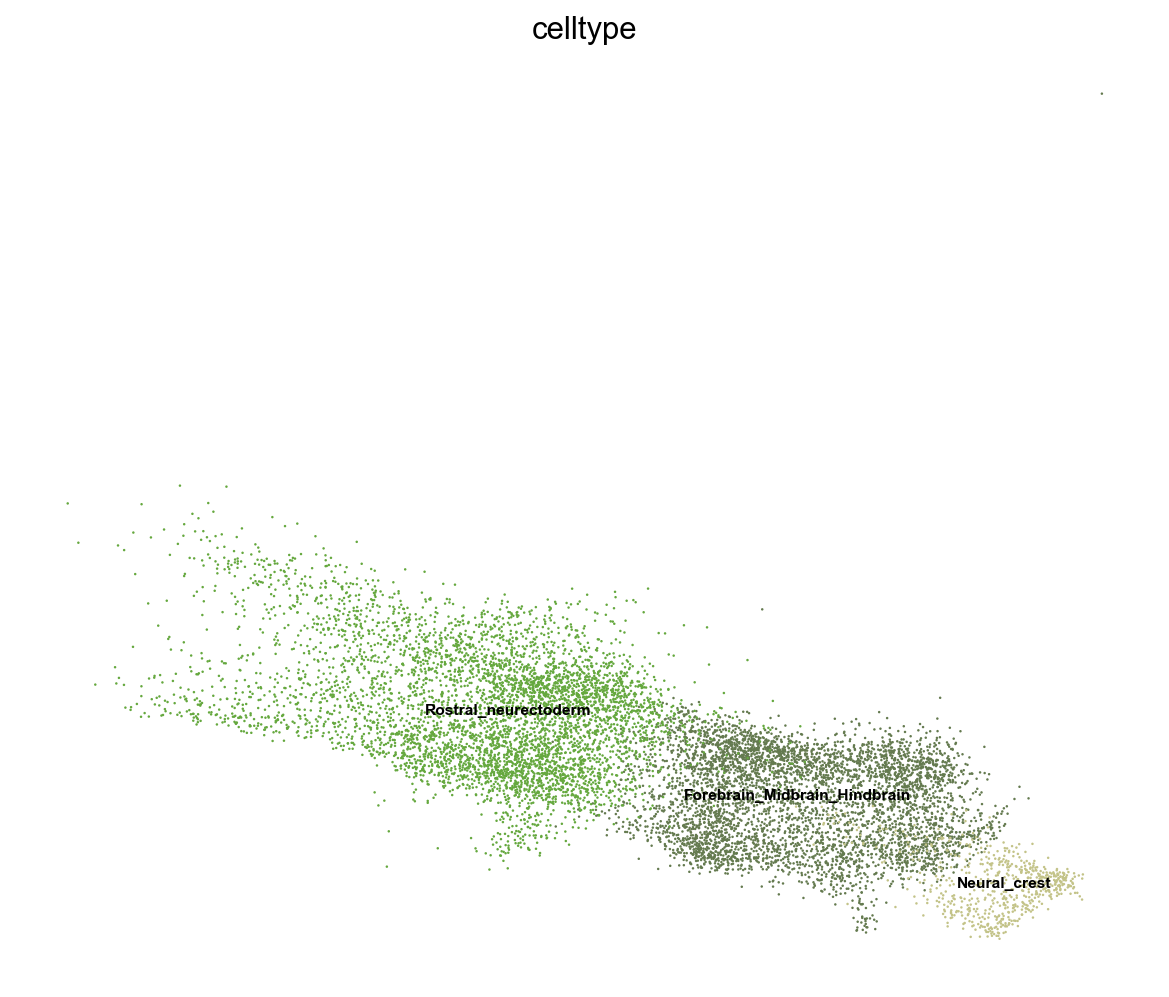

In [44]:
sc.pl.scatter(adata, color='celltype', basis="umap", size=5, legend_loc='on data', legend_fontsize=7)

## Feature selection

In [45]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

In [46]:
adata.var["highly_variable"].sum()

1000

## Dimensionality reduction

### PCA

In [47]:
sc.tl.pca(adata, n_comps=15)

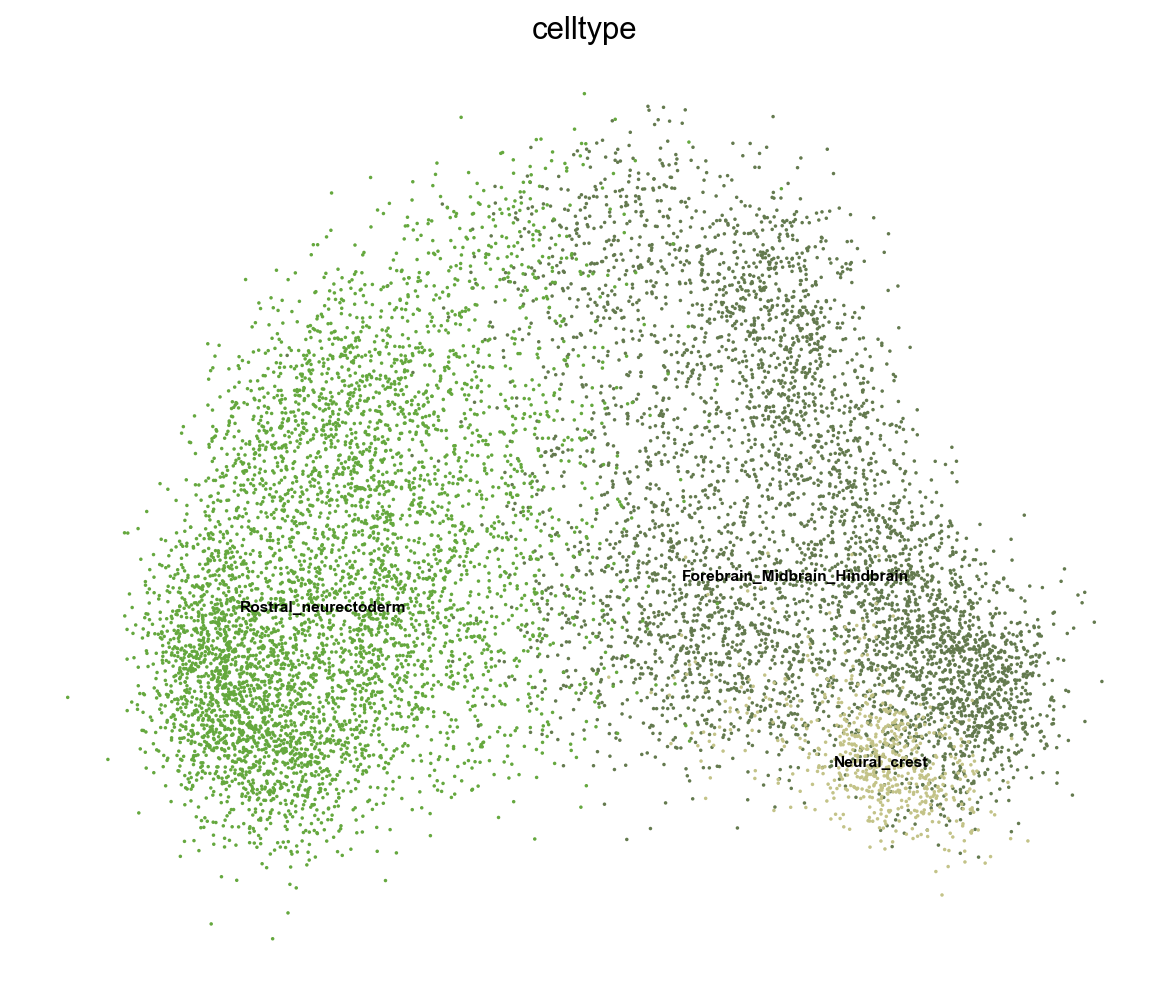

In [48]:
sc.pl.scatter(adata, color='celltype', basis="pca", size=10, legend_loc='on data', legend_fontsize=7, 
              save="blood_pca_celltype.pdf")

## Compute neighbors

In [49]:
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca')

### UMAP

In [50]:
sc.tl.umap(adata, min_dist=0.3, spread=1.0)

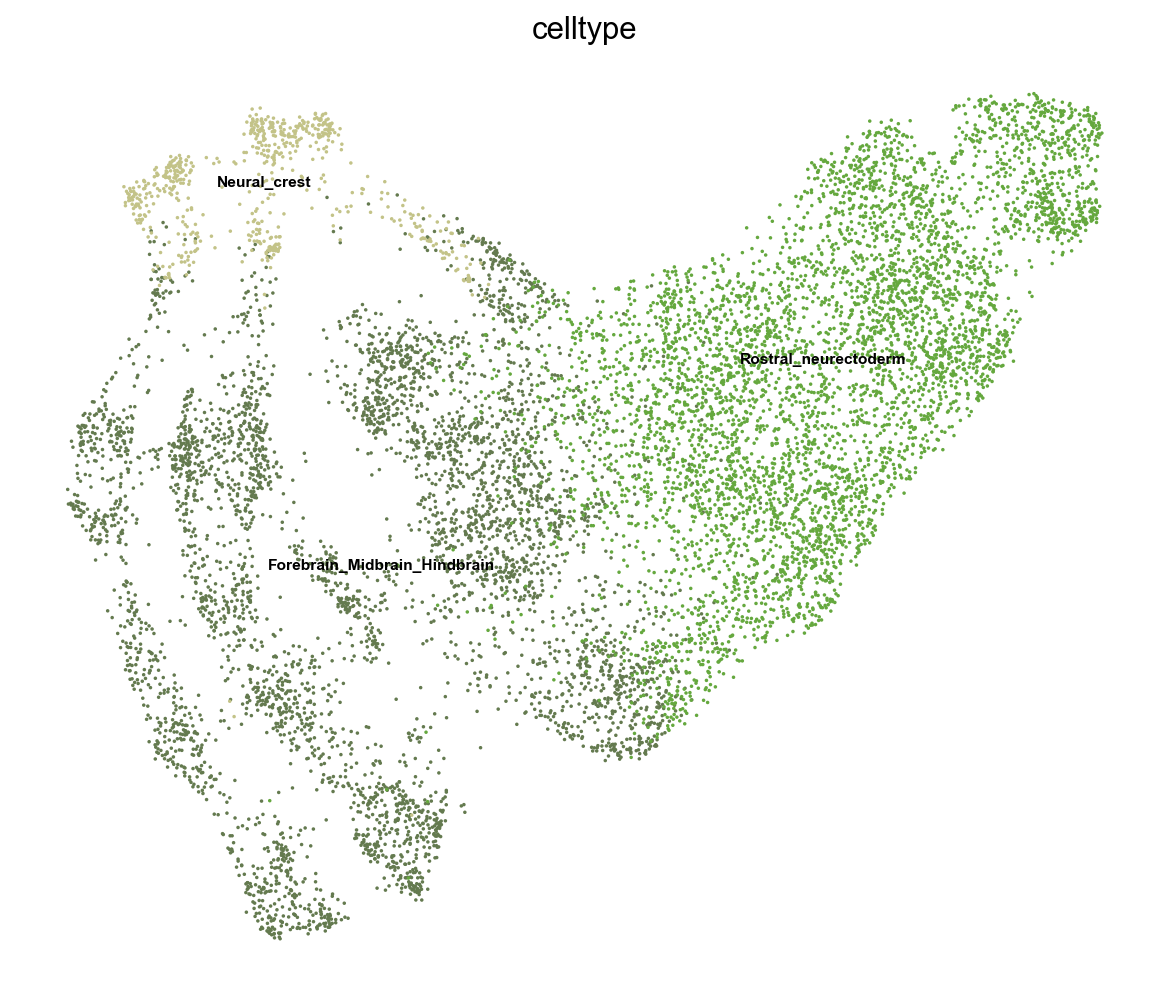

In [51]:
sc.pl.scatter(adata, color='celltype', basis="umap", size=10, legend_loc='on data', legend_fontsize=7,
              save = "blood_umap_celltype.pdf")

In [52]:
adata.obsm.keys()

KeysView(AxisArrays with keys: X_pca, X_umap, X_tsne, X_diffmap)

### Force-directed layout

In [53]:
sc.tl.draw_graph(adata, layout='fa', init_pos=None)

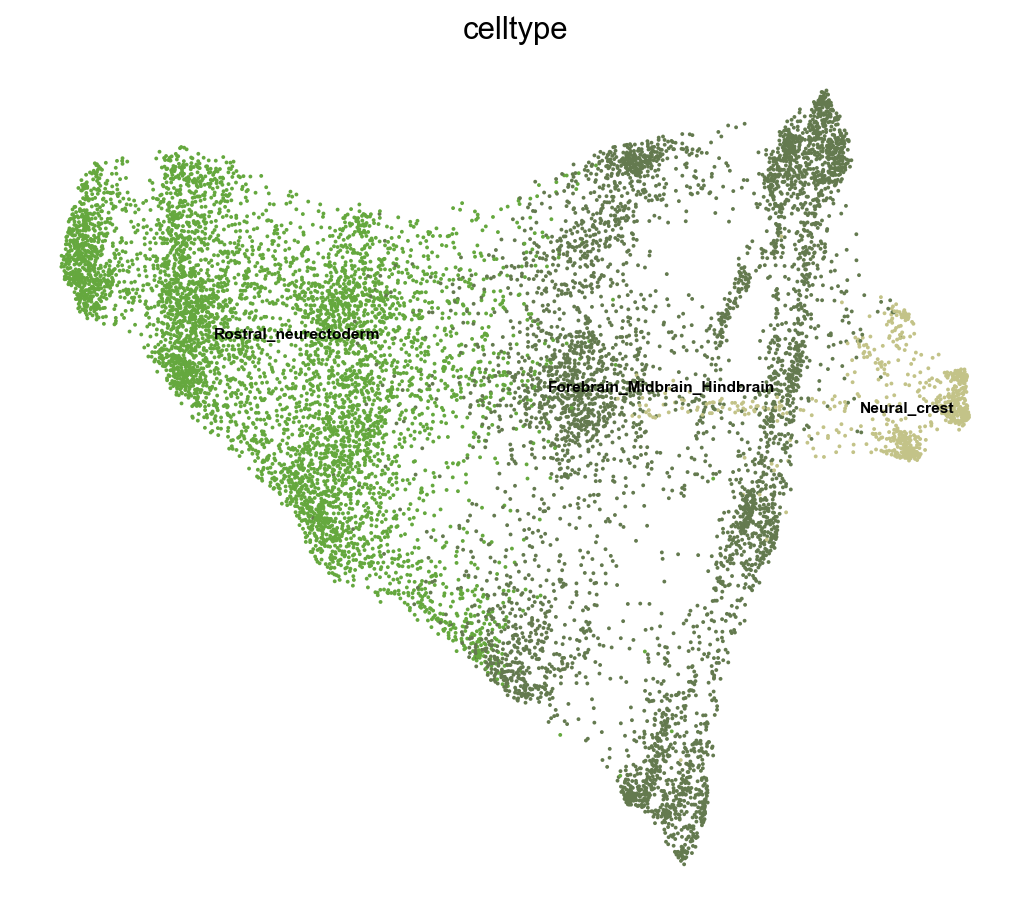

In [54]:
# sc.pl.draw_graph(adata, color='celltype', legend_loc='on data')
sc.pl.draw_graph(adata, color='celltype', size=12, legend_loc='on data', legend_fontsize=7,
              save = "blood_fa2_celltype.pdf")

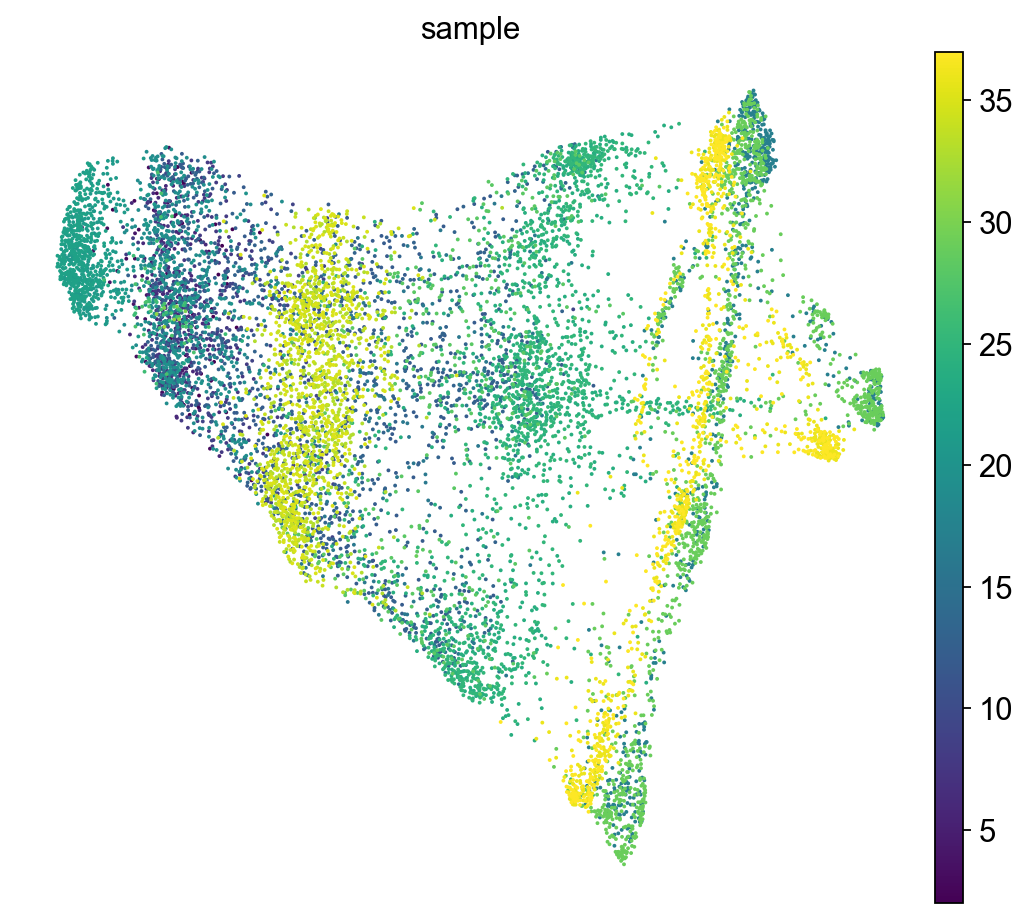

In [55]:
sc.pl.draw_graph(adata, color='sample', size=12, legend_loc='on data', legend_fontsize=7,
              save = "blood_fa2_sample.pdf")

## Save

In [56]:
trajectory = pd.DataFrame(adata.obsm["X_draw_graph_fa"], index=adata.obs_names, columns=["FA1","FA2"])
# trajectory.to_csv(io["outdir"] + "/blood_trajectory.txt.gz", sep='\t')

In [57]:
# adata.write(io["outdir"] + "/blood_anndata.h5ad")
# metadata.to_csv(io["outdir"] + "/blood_sample_metadata.txt.gz", sep='\t')